In [11]:
import numpy as np 
import pandas as pd
import torch
import os
from PIL import Image
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from pathlib import Path
from os.path import dirname, abspath
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
#Altered to work on cluster ?
os.chdir("/datasets" + "/MaskedFace-Net")

In [13]:
transform_train = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
transform_val = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [15]:
maskedface_net_train = torchvision.datasets.ImageFolder("../MaskedFace-Net/train", transform=transform_train)

In [16]:
maskedface_net_val = torchvision.datasets.ImageFolder("../MaskedFace-Net/validation", transform=transform_val)

In [17]:
data_loader_train = torch.utils.data.DataLoader(maskedface_net_train,
                                          batch_size=4, #32
                                          shuffle=True)

In [18]:
data_loader_val = torch.utils.data.DataLoader(maskedface_net_val,
                                             batch_size=4, #32
                                             shuffle=True)

In [19]:
maskedface_net_train[0][0].size()

torch.Size([3, 32, 32])

In [20]:
classes = ('correctly masked', 'incorrectly masked', 'not masked')

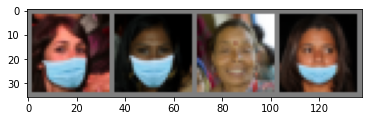

correctly masked | correctly masked | not masked | incorrectly masked


In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(data_loader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' | '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 3, 5, 5])


In [24]:
images.shape

torch.Size([4, 3, 32, 32])

In [62]:
%%time
#Training the model on the entire dataset. Batch size of 4
batch_g = []
ep = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 499))
            batch_g.append(epoch + 1)
            ep.append(running_loss / 499)
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 1.276
[1,  1000] loss: 0.215
[1,  1500] loss: 0.152
[1,  2000] loss: 0.116
[1,  2500] loss: 0.093
[1,  3000] loss: 0.089
[1,  3500] loss: 0.063
[1,  4000] loss: 0.057
[1,  4500] loss: 0.042
[1,  5000] loss: 0.047
[1,  5500] loss: 0.034
[1,  6000] loss: 0.053
[1,  6500] loss: 0.051
[1,  7000] loss: 0.043
[1,  7500] loss: 0.044
[1,  8000] loss: 0.039
[1,  8500] loss: 0.035
[1,  9000] loss: 0.046
[2,   500] loss: 0.028
[2,  1000] loss: 0.018
[2,  1500] loss: 0.029
[2,  2000] loss: 0.029
[2,  2500] loss: 0.043
[2,  3000] loss: 0.020
[2,  3500] loss: 0.034
[2,  4000] loss: 0.023
[2,  4500] loss: 0.027
[2,  5000] loss: 0.029
[2,  5500] loss: 0.036
[2,  6000] loss: 0.046
[2,  6500] loss: 0.024
[2,  7000] loss: 0.029
[2,  7500] loss: 0.031
[2,  8000] loss: 0.021
[2,  8500] loss: 0.027
[2,  9000] loss: 0.042
Finished Training
CPU times: user 2h 45min 48s, sys: 5min 44s, total: 2h 51min 33s
Wall time: 48min 19s


In [63]:
#Saving the above model
os.chdir('/home/gatran/DSC180B-Face-Mask-Detection/notebooks')
PATH = '../src/models/model_v4.pt' #Model Above, model_v2 wasn't that good but don't want to overwrite*
torch.save(net.state_dict(), PATH)

The black bar represents the Error or in other words the variability of data


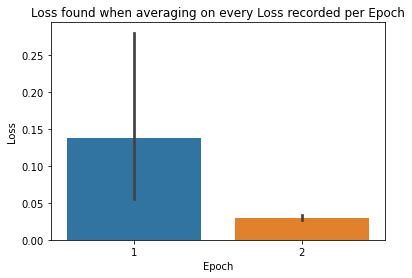

In [64]:
df = pd.DataFrame(list(zip(batch_g, ep)), columns = ['Epoch', 'Loss'])

sns.barplot(data=df, x = "Epoch", y = "Loss").set_title("Loss found when averaging on every Loss recorded per Epoch")

print("The black bar represents the Error or in other words the variability of data")

In [68]:
%%time
#Training the model on the entire dataset. Batch size of 32

#Get the right filepath
os.chdir("/datasets" + "/MaskedFace-Net")

data_loader_train = torch.utils.data.DataLoader(maskedface_net_train,
                                          batch_size=32,
                                          shuffle=True)


batch_g = []
ep = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 293 mini batches [37500/(batch size == 32)/4 (for graphical purposes)]
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 499))
            batch_g.append(epoch + 1)
            ep.append(running_loss / 499)
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.022
[1,  1000] loss: 0.022
[2,   500] loss: 0.021
[2,  1000] loss: 0.022
Finished Training
CPU times: user 47min 46s, sys: 3min 6s, total: 50min 53s
Wall time: 34min 57s


In [66]:
os.chdir('/home/gatran/DSC180B-Face-Mask-Detection/notebooks')
PATH = '../src/models/model_v5.pt' #Model Above, model_v3 wasn't that good but don't want to overwrite*
torch.save(net.state_dict(), PATH)

In [25]:
%%time 

#Go to the correct file path
os.chdir('/home/gatran/DSC180B-Face-Mask-Detection/notebooks')

#Accuracy on the validation set with a batch size of 4

#Load in the saved training model
net = Net()
net.load_state_dict(torch.load("../src/models/model_v4.pt"))

#Change filepath back to where the dataset is
os.chdir("/datasets" + "/MaskedFace-Net")

data_loader_val = torch.utils.data.DataLoader(maskedface_net_val,
                                             batch_size=4,
                                             shuffle=True)

#Accuracy section
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(data_loader_val):
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))

Accuracy of the network on the validation set: 99 %
CPU times: user 7min 35s, sys: 5.26 s, total: 7min 40s
Wall time: 4min 29s


In [26]:
output = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' | '.join('%5s' % classes[predicted[j]] for j in range(1)))

Predicted:  correctly masked


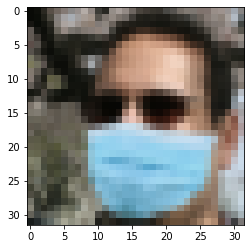

In [27]:
imshow(torchvision.utils.make_grid(inputs))

In [28]:
%%time 

#Accuracy on the validation set with a batch size of 32

#Go back to correct file path
os.chdir('/home/gatran/DSC180B-Face-Mask-Detection/notebooks')

#Load in the saved training model
net = Net()
net.load_state_dict(torch.load("../src/models/model_v5.pt"))

data_loader_val = torch.utils.data.DataLoader(maskedface_net_val,
                                             batch_size=32,
                                             shuffle=True)

#Change filepath back to where the dataset is
os.chdir("/datasets" + "/MaskedFace-Net")

#Accuracy section
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(data_loader_val):
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))

Accuracy of the network on the validation set: 99 %
CPU times: user 4min 5s, sys: 26.3 s, total: 4min 32s
Wall time: 4min 9s


In [29]:
output = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' | '.join('%5s' % classes[predicted[j]] for j in range(29)))

Predicted:  correctly masked | not masked | incorrectly masked | incorrectly masked | not masked | incorrectly masked | correctly masked | correctly masked | incorrectly masked | correctly masked | not masked | correctly masked | incorrectly masked | correctly masked | incorrectly masked | not masked | incorrectly masked | incorrectly masked | incorrectly masked | not masked | not masked | correctly masked | incorrectly masked | correctly masked | correctly masked | incorrectly masked | incorrectly masked | not masked | not masked


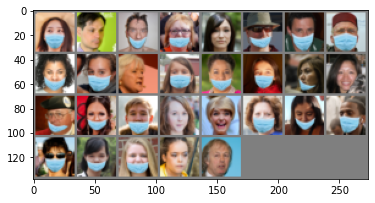

In [30]:
imshow(torchvision.utils.make_grid(inputs))